In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
# !pip3 install transformations
import transformations as tf

In [22]:
# file_dir = '/home/thiruchl/catkin_ws/src/rob590-multi-agent-localization/src/DATA/Sample-Data/collected/'
# folder_name = 'noise_0/' #change
# file_name_gt = 'stamped_groundtruth.txt'
# file_name_est = 'stamped_traj_estimate.txt'
# file_name_matches = 'saved_results/traj_est/stamped_est_gt_matches.txt'
# path_gt = file_dir + folder_name + file_name_gt
# path_est = file_dir + folder_name + file_name_est
# path_matches = file_dir + folder_name + file_name_matches

In [23]:
file_dir = '/home/thiruchl/catkin_ws/src/rob590-multi-agent-localization/src/DATA/Sample-Data/collected/'
file_dir = '/home/thiruchl/ROB530/Localiztion/ROB530_Localization-working_PF/'
file_name_gt = 'stamped_groundtruth.txt'
file_name_est = 'stamped_traj_estimate.txt'
file_name_matches = 'saved_results/traj_est/stamped_est_gt_matches.txt'
path_gt = file_dir +  file_name_gt
path_est = file_dir +  file_name_est
path_matches = file_dir + file_name_matches

In [24]:
with open(path_gt) as f:
    gt = np.loadtxt(f)
with open(path_est) as f:
    est = np.loadtxt(f)
with open(path_matches) as f:
    matches = np.loadtxt(f)

print(gt.shape)
print(est.shape)
print(matches.shape)

(4855, 8)
(2939, 8)
(2914, 2)


In [25]:
aligns = len(matches)
aligned_w_time = np.empty((aligns, 16))
aligned_pose = np.empty((aligns, 14))
aligned_prpy = np.empty((aligns, 12))
aligned_dist = np.zeros((aligns,1))

In [26]:
# EST GT
start = (est[int(matches[0,0]), 1], est[int(matches[0,0]), 2])
for i in range(aligns):
    est_i = int(matches[i, 0])
    gt_i = int(matches[i, 1])
    aligned_w_time[i, :8] = est[est_i,:] 
    aligned_w_time[i, 8:] = gt[gt_i,:] 
    aligned_pose[i, :7] = est[est_i,1:] 
    aligned_pose[i, 7:] = gt[gt_i,1:] 
    aligned_prpy[i, 0:3] = est[est_i,1:4] 
    aligned_prpy[i, 6:9] = gt[gt_i,1:4] 
    quat_est = est[est_i, 4:]
    quat_gt = gt[gt_i, 4:]
    R_est = tf.quaternion_matrix(quat_est)
    R_gt = tf.quaternion_matrix(quat_gt)
    ypr_est = tf.euler_from_matrix(R_est, 'rzyx')
    ypr_gt = tf.euler_from_matrix(R_gt, 'rzyx')
    aligned_prpy[i, 3:6] = ypr_est
    aligned_prpy[i, 9:12] = ypr_gt
    aligned_dist[i] = np.sqrt((est[est_i, 1] - start[0])**2 + (est[est_i,2] - start[1])**2)
    

[3.01561576e+02 2.04058212e+01 2.55760233e+00 2.21459101e-01
 1.63813606e-03 3.37850974e-02]


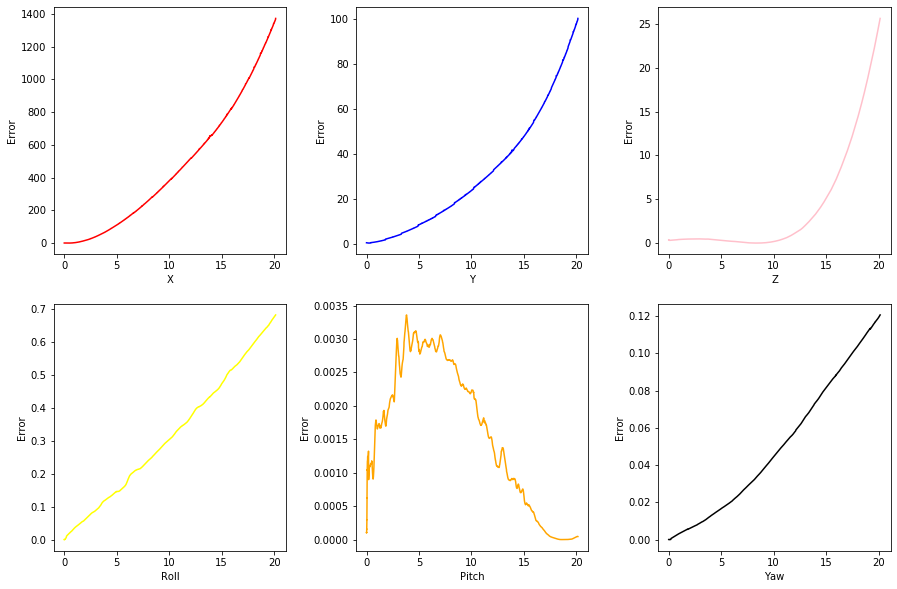

In [27]:
error = np.concatenate((aligned_prpy[:,0:3] - aligned_prpy[:,6:9], aligned_prpy[:, 3:6] - aligned_prpy[:,9:12]), axis = 1)
error_sq = error**2
mse = np.mean(error_sq, axis=0)
print(mse)
colors = ['red', 'blue', 'pink', 'yellow', 'orange', 'black']
xlabel = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
c=0
for i in range(6):
    axs[c, i%3].plot(aligned_dist, error_sq[:,i], colors[i])
    axs[c, i%3].set_xlabel(xlabel[i])
    axs[c, i%3].set_ylabel('Error')
    if i==2:
        c=1
    # plt.show()
    plt.subplots_adjust(wspace=0.3)

2914


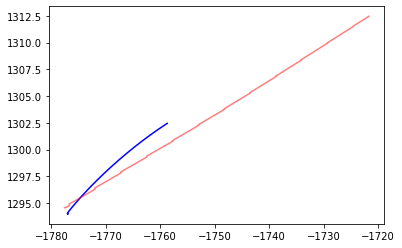

In [30]:
plt.plot(aligned_prpy[:,0],aligned_prpy[:,1], 'blue')
# plt.show()
plt.plot(aligned_prpy[:,6], aligned_prpy[:,7], 'red', alpha = 0.5)
print(len(aligned_prpy[:,6]))

In [ ]:
from scipy.spatial.transform import Rotation
from statistics import mean
from scipy.linalg import block_diag
from copy import deepcopy, copy
import rospy
import numpy as np
from system.RobotState import RobotState
from geometry_msgs.msg import PoseStamped, PoseWithCovarianceStamped
from utils.utils import wrap2Pi, wrap_all_angles, mat_from_quat, getRPY

from scipy.stats import multivariate_normal
from numpy.random import default_rng
rng = default_rng()
from comm.path_publisher import *

from pyquaternion import Quaternion
import sys

class PF:
    # PF construct an instance of this class
    #
    # Inputs:
    #   system: system and noise models
    #   init:   initial state mean and covariance

    def __init__(self, system, init):
        np.random.seed(20)
        self.gfun = system.gfun  # motion model
        self.hfun = system.hfun  # measurement model
        self.Q = system.Q # measurement noise covariance
        
        # PF parameters
        self.n = init.n
        self.Sigma = init.Sigma
        self.particles = init.particles
        self.particle_weight = init.particle_weight

        
        self.state_ = RobotState()
        self.mu = init.mu
        self.cov = init.Sigma
        self.output_publisher = rospy.Publisher('/filtered', PoseWithCovarianceStamped, queue_size=100000)
        self.check = 0
    
    def prediction(self, delta):
        ###############################################################################
        # TODO: Implement the prediction step for PF, remove pass                     #
        # Hint: Propagate your particles. Particles are saved in self.particles       #
        # Hint: Use rng.standard_normal instead of np.random.randn.                   #
        #       It is statistically more random.                                      #
        ###############################################################################
        if self.check!=0:
            assert delta!=0
        for i in range(len(self.particles[0])):
            mat = self.gfun(self.particles[:,i], delta)
            self.particles[:,i] = np.matmul(mat, self.particles[:,i].reshape((-1,1))).reshape((-1,))
        print("predicting", delta, self.mu)
        ###############################################################################
        #                         END OF YOUR CODE                                    #
        ###############################################################################

    def correction(self, z, time):
        
        ###############################################################################
        # TODO: Implement the correction step for PF                                  #
        # Hint: self.mean_variance() will update the mean and covariance              #
        # Hint: you can use landmark1.getPosition()[0] to get the x position of 1st   #
        #       landmark, and landmark1.getPosition()[1] to get its y position        #
        ###############################################################################
        
        # calculate measurement and difference in measurements
        
        for i in range(len(self.particles[0])):
            # compute identity transform of pose
            model_measurement = self.hfun(self.particles[:, i])
            # rot_mat = mat_from_quat(z[3:])
            # yaw, pitch, roll = getRPY(rot_mat)
            
            aa = Rotation.from_quat(z[3:]).as_euler('xyz')
            # yaw, pitch, roll = aa[0], aa[1], aa[2]
            roll, pitch, yaw = aa[0], aa[1], aa[2]

            z_6 = np.array([z[0],z[1],z[2], roll, pitch, yaw])
            
            # z_diff = z_6 - model_measurement
            # # print(z_diff, "z_diff \n")


            dist = multivariate_normal(z_6, self.Q)
            self.particle_weight[i] *= dist.pdf(model_measurement)
        if self.check!=0:
            print(self.check)
            assert np.sum(self.particle_weight)!=0
        self.check=1
        print("summm", np.sum(self.particle_weight))

        self.particle_weight = self.particle_weight/ np.sum(self.particle_weight)
        assert np.sum(self.particle_weight)>=0.9 and np.sum(self.particle_weight) <=1.1
        print("correcting", self.mu)
        
        position = self.mu[0:3]
        orientation = Rotation.from_euler('xyz', self.mu[3:6])
        orientation = orientation.as_quat()

        pose_to_publish = PoseWithCovarianceStamped()
        pose_to_publish.pose.pose.position.x = position[0]
        pose_to_publish.pose.pose.position.y = position[1]
        pose_to_publish.pose.pose.position.z = position[2]
        
        pose_to_publish.pose.pose.orientation.x = orientation[0]
        pose_to_publish.pose.pose.orientation.y = orientation[1]
        pose_to_publish.pose.pose.orientation.z = orientation[2]
        pose_to_publish.pose.pose.orientation.w = orientation[3]

        pose_to_publish.header.stamp = time

        self.output_publisher.publish(pose_to_publish)

        neff = 1/np.sum(self.particle_weight**2) # effective sample size
        if neff < self.n - 50:
            print("resampling \n \n resampling")
            self.resample()

        with open('/home/thiruchl/ROB530/Localiztion/ess.txt', 'a') as f:
            f.write(str(neff)+'\n')

        self.mean_variance_3D()

    def resample(self):
        new_samples = np.zeros_like(self.particles)
        new_weight = np.zeros_like(self.particle_weight)
        W = np.cumsum(self.particle_weight)
        r = np.random.rand(1) / self.n
        count = 0
        for j in range(self.n):
            u = r + j/self.n
            # print(j, u, W.shape, count)
            # print(W[count], np.max(W))
            while u > W[count]:
                count += 1
                # print('in', count)
            # print("out while", count)
            new_samples[:,j] = self.particles[:,count]
            new_weight[j] = 1 / self.n
        self.particles = new_samples
        self.particle_weight = new_weight
    
    def mean_variance_3D(self):
        # self.mu = np.mean(self.particles, axis= 1)
        # quat = self.particles[3:7, :]
        # ang = Rotation.from_quat(quat.T)
        # ang1 = ang.as_euler('xyz')
        # mean_ang = Rotation.from_euler('xyz', ang1).mean()
        # # mean_ang = Rotation.mean(Rotation.from_euler('xyz', ang1))
        # self.mu[3:6] = mean_ang.as_euler('xyz')
        # new_part = np.concatenate((self.particles[0:3,:], ang1.T, self.particles[6:, :]))
        # new_sub = new_part - self.mu.reshape((-1,1))
        # self.cov = np.matmul(new_sub, new_sub.T) / self.n
        # assert self.cov.shape[0] ==15 and self.cov.shape[1] == 15

        self.mu = np.mean(self.particles, axis= 1)
        ang = self.particles[3:6, :]
        ang = Rotation.from_euler('xyz', ang.T)
        ang1 = ang.as_euler('xyz')
        mean_ang = ang.mean()
        # mean_ang = Rotation.mean(Rotation.from_euler('xyz', ang1))
        self.mu[3:6] = mean_ang.as_euler('xyz')
        new_part = np.concatenate((self.particles[0:3,:], ang1.T, self.particles[6:, :]))
        new_sub = new_part - self.mu.reshape((-1,1))
        self.cov = np.matmul(new_sub, new_sub.T) / self.n
        assert self.cov.shape[0] ==15 and self.cov.shape[1] == 15

        # self.mu = np.mean(self.particles, axis= 1)
        # ang = self.particles[3:6, :]
        # ang = Rotation.from_euler('xyz', ang.T)
        # ang1 = ang.as_euler('xyz')
        # mean_ang = ang.mean()
        # # mean_ang = Rotation.mean(Rotation.from_euler('xyz', ang1))
        # self.mu[3:6] = mean_ang.as_euler('xyz')
        # new_part = np.concatenate((self.particles[0:3,:], ang1.T))
        # new_sub = new_part - self.mu.reshape((-1,1))
        # self.cov = np.matmul(new_sub, new_sub.T) / self.n
        # assert self.cov.shape[0] == 6 and self.cov.shape[1] == 6
    

    def getState(self):
        return deepcopy(self.state_)

    def setState(self, state):
        self.state_ = state

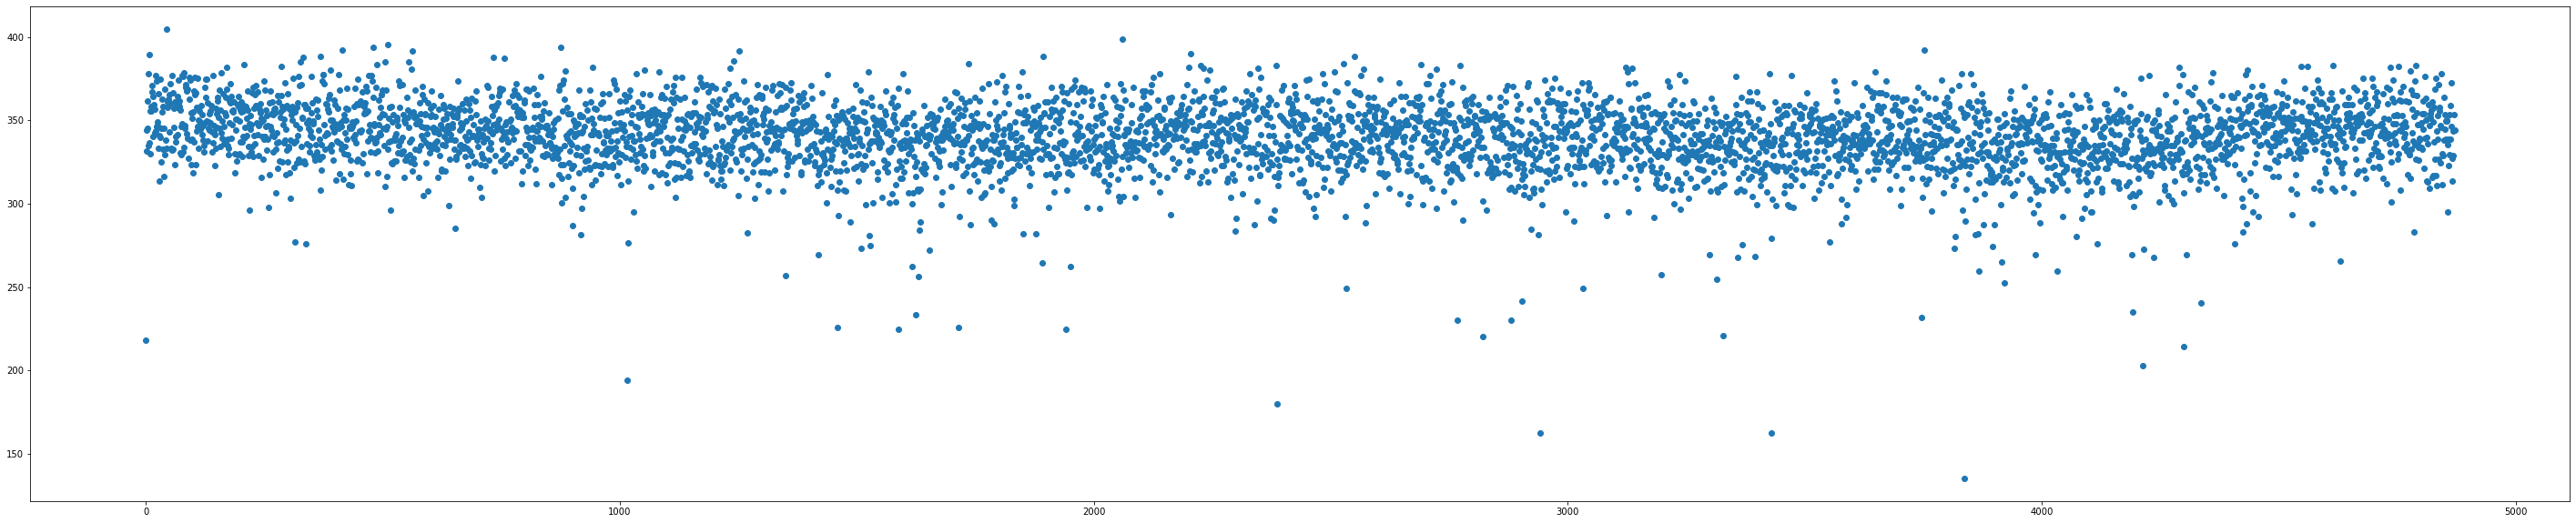

In [24]:
import numpy as np
import matplotlib.pyplot as plt

with open('/home/thiruchl/ROB530/Localiztion/ess.txt') as t:
    ess = np.loadtxt(t)

fig, ax = plt.subplots(figsize=(50, 10))
ax.scatter(np.arange(0,len(ess)), ess)

# ax.set_xlim(0, 10000)